In [234]:
from requests_html import AsyncHTMLSession, HTMLSession
from bs4 import BeautifulSoup
import asyncio
import logging
import json
import time
import re

logging.disable(logging.WARNING)

In [235]:
def debug_print(message, debug=True):
    
    if debug:
        print(message)

def convert_keys_to_int(json_dict):
    
    return { (int(key) if key.isdigit() else key): value for key, value in json_dict.items() }

def load_json(path, edition=None, articles=None):
    
    try:
        with open(path + '.json', 'r', encoding='utf-8') as file:
            return json.load(file, object_hook=convert_keys_to_int)

    except (FileNotFoundError, json.JSONDecodeError):
        with open(path + '.json', 'w', encoding='utf-8') as file:
            json.dump({ }, file, ensure_ascii=False, indent=4)
        return { }

def save_json(path, entries, edition=None, reset=False):
    
    temp_entries = entries   
    entries = ({ edition: { } } if edition else { }) if reset else load_json(path)

    (entries[edition] if edition else entries).update(temp_entries)
    
    try:
        with open(path + '.json', 'w', encoding='utf-8') as file:
            json.dump(entries, file, ensure_ascii=False, indent=4)

    except:
        pass
        
def find_missing_articles(edition, articles, path):

    return articles - load_json(path).get(edition, { }).keys()

In [236]:
async def fetch_article(
    edition, article, session=AsyncHTMLSession(), semaphore=asyncio.Semaphore(), max_tries=5, debug=False):
    
    url = f'https://nordiskfamiljebok.dh.gu.se/article/{edition}/{article}'
    
    async with semaphore:

        debug_print(f"Fetching {'1st' if article == 1 else f'{article}nd'} article from {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
        
        for n in range(1, max_tries + 1):
            try:
                response = await session.get(url)
                await response.html.arender(timeout=5*n, sleep=5*n)
                
                debug_print(f"Successfully fetched article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
                
                return response.html
                
            except:
                debug_print(f"Failed to fetch article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition.\nRetrying with larger timeout...", debug)
    
    debug_print(f"Failed to fetch article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
     
    return None

async def fetch_articles(
    edition, articles, path='articles', force_fetch=False,
    max_concurrent_tasks=5, max_tries=5, debug=False):
    
    if not force_fetch:
        articles = find_missing_articles(edition, articles, path)

    session = AsyncHTMLSession()
    semaphore = asyncio.Semaphore(max_concurrent_tasks)
    
    async with asyncio.TaskGroup() as task_group:
        tasks = [
            task_group.create_task(
                fetch_article(edition, article, session, semaphore, max_tries, debug))
            for article in articles
        ]

    entries = { edition: { } }
    
    for (task, article) in zip(tasks, articles):
        
        try:
            html = task.result().html 
            soup = BeautifulSoup(html, "html.parser")

            entries[edition][article] = {
                'html': html,
                'title': soup.find('h1', {'data-v-5ad7308b': True}).decode_contents(),
                'text': soup.find('article', {'data-v-5ad7308b': True}).decode_contents()
                }
        except:
            pass

    return entries

async def load_articles(
    edition, articles, path='articles', force_fetch=False,
    max_concurrent_tasks=5, sort=False, max_tries=5, debug=False):
    
    entries = load_json(path)
    entries.setdefault(edition, { })
    
    fetched_entries = await fetch_articles(
        edition, articles, path, force_fetch, max_concurrent_tasks, max_tries, debug)
    
    entries[edition].update(fetched_entries.get(edition, { }))

    if sort:
        entries = { key: dict(sorted(value.items())) for key, value in sorted(entries.items()) }

    save_json(path, entries)

    return { key: value for values in entries.values() for key, value in values.items() if key in articles}

In [248]:
import unicodedata
import locale

locale.setlocale(locale.LC_COLLATE, 'sv_SE.UTF-8')

def segment_text(text):

    segments = re.split(r"\s*(?:<br\s*/?>)+\s*", text)

    last_valid_segment = None
    last_valid_word = None
    valid_segments = {}

    for segment in segments:
        # segment = unicodedata.normalize('NFC', segment)
        clean_segment = re.sub(r"<.*?>", '', segment).strip().lower()

        try:
            first_word = re.match(r"\b(\w[\w']*)", clean_segment).group(0)  # Match the first word
            first_word_uml = re.sub(r'ii', 'ü', first_word)
        except:
            first_word = first_word_uml = ''

        if last_valid_segment:

            if (last_valid_word < first_word or last_valid_word < first_word_uml
                and (re.match(r"[\w'-]+[\s]*[.,\(\[]", clean_segment))):
                valid_segments[last_valid_word] = last_valid_segment
                last_valid_segment = clean_segment
                last_valid_word = first_word
                #print("NEW -", "HEAD:", first_word, "SEGMENT:", clean_segment)

            else:
                last_valid_segment += '\n' + clean_segment
                #print("OLD -", "HEAD:", first_word, "SEGMENT:", clean_segment)
        else:
            #print("NEW -", "HEAD:", first_word, "SEGMENT:", clean_segment)
            last_valid_segment = clean_segment
            last_valid_word = first_word

    valid_segments[last_valid_word] = last_valid_segment
    
    return valid_segments

async def load_segments(
    edition, articles, articles_path='articles', segments_path='segments',
    force_fetch=False, max_concurrent_tasks=10, sort=False,
    max_tries=5, force_segmentation=False, debug=False):
    
    entries = load_json(segments_path)  
    entries.setdefault(edition, { })
    
    segment_articles = articles if force_segmentation else find_missing_articles(edition, articles, segments_path)

    article_entries = (await load_articles(
        edition, segment_articles, articles_path, force_fetch, max_concurrent_tasks, sort, max_tries, debug))
 
    for article in segment_articles:
        text = article_entries[article]['text']
        
        entries[edition][article] = [
            {
                'head': head,
                'segment': segment,
                'label': 'Other'
            } for head, segment in segment_text(text).items()
        ]
            
    if sort:
        entries = { key: dict(sorted(value.items())) for key, value in sorted(entries.items()) } 

    save_json(segments_path, entries)

    return { key: value for values in entries.values() for key, value in values.items() if key in articles}

In [252]:
edition = 2
articles = range(1, 1001)

article_entries = await load_articles(edition, articles, sort=True)
#segment_entries = await load_segments(edition, articles, sort=True, force_segmentation=True)

In [250]:
article_entries[500]

{'html': '<!DOCTYPE html><html lang="en"><head><meta charset="utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="viewport" content="width=device-width,initial-scale=1"><script src="/scanned1.js"></script><script src="/scanned2.js"></script><link rel="icon" href="/favicon.ico"><title>Nordisk familjebok</title><link href="/css/article.9b415184.css" rel="prefetch"><link href="/js/article.8f692e99.js" rel="prefetch"><link href="/css/app.f88a90c6.css" rel="preload" as="style"><link href="/css/chunk-vendors.42603ac5.css" rel="preload" as="style"><link href="/js/app.d051af76.js" rel="preload" as="script"><link href="/js/chunk-vendors.0a3c5501.js" rel="preload" as="script"><link href="/css/chunk-vendors.42603ac5.css" rel="stylesheet"><link href="/css/app.f88a90c6.css" rel="stylesheet"><link rel="stylesheet" type="text/css" href="/css/article.9b415184.css"><script charset="utf-8" src="/js/article.8f692e99.js"></script></head><body class="cdh-body"><noscript>We\'re sorry but

In [251]:
segment_entries[1]

[{'head': 'a',
  'segment': 'a är den första bokstafven i alla indoeuropeiska språks alfabet utom i den vanliga runföljden, der det innehar det tionde rummet. det är tillika det renaste och klaraste af alla språkljud och har på ljudskalan sin plats mellan i och u, med hvilka vokaler det omvexlande förekommer dels i olika språk af samma stam i beteckningar af lika eller närstående begrepp, t.ex. sanskr. agni, lat. ignis, littau. ugnis (hvilka alla betyda eld), sv. ugn, dels i ett och samma språk vid ordböjning (finna, fann, funnen) eller ordbildning (bindel, band, bundt). svenskan eger ett kort och öppet a, t. ex. i grann, kall, samt ett långt och slutet, t. ex. i gran, kal. i de nyare språken och icke minst i vårt eget, särdeles i våra landskapsmål, visar a benägenhet att sjunka och fördunklas till mer eller mindre grumliga ä- (e-) eller å-ljud, t. ex. svärt för svart, värm för varm, ligge för ligga, å l. åv för af, sått för satt. dock är vårt modersmål ännu så rikt på rena och välljud

In [ ]:
import pandas as pd
import keyboard
import time

idx2cat = {
    0: 'Undefined',
    1: 'Person',
    2: 'Location',
    3: 'Other'
}

#splits = {'train': 'train.json', 'validation': 'validation.json'}
#df = pd.read_json("hf://datasets/pnugues/nf_1876/" + splits["train"])
df = pd.read_csv('annotations.csv', index_col=0)

i = 0
last_i = -1

filtered_df = df[df['label'] == 0].index

exit = False

actions = {
    '1': 'Label as location',
    '2': 'Label as other',
    '3': 'Go back one step',
    '4': 'Save',
    '5': 'Exit'
}


print('Inputs:\n')

for key, action in actions.items():
    print(f'{key}. {action}')

print()

while (True):
    
    item = df.loc[filtered_df[i]]
    
    text = item['text']
    label = item['label']
    
    if last_i != i:
        print(f'{i+1}/{len(filtered_df)}:\nText: {text}\nLabel: {idx2cat[label]}\n')

    last_i = i
    
    key_press = keyboard.read_key()

    if key_press in actions.keys():
        print(f'You chose \'{actions[key_press]}\'\n')
    
    if key_press in { '1', '2'}:
        df.loc[filtered_df[i], 'label'] = int(key_press) + 1
        i = min(i + 1, len(df) - 1)
        
    if key_press == '3':
        i = max(i - 1, 0)
    
    if key_press == '4':
        df.to_csv('annotations_edited.csv', index=False)
        
    if key_press == "5":
        break
    
    time.sleep(0.2)

Inputs:

1. Label as location
2. Label as other
3. Go back one step
4. Save
5. Exit

1/200:
Text: <b>Apprehension</b> (Lat. apprehénsio, af <i>apprehéndere</i>), <i>jur.,</i> den handling, hvarigenom en person tager en sak i besittning.
Label: Undefined

You chose 'Label as location'

2/200:
Text: Atakamit, ett kopparmineral, bestående av ba-sisk kopparklorid, förekommer bl. a. i Bolivia och Chile.
Label: Undefined

You chose 'Exit'



In [242]:
from datasets import Dataset
df = pd.read_csv('annotations_edited.csv', index_col=0)

segments = df[df['label'] != 0]

segments.loc[:, 'label'] = segments['label'] - 1

segments = Dataset.from_pandas(segments)
segments = segments.train_test_split(test_size=0.2)
segments

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 313
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 79
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [202]:
segments_encoded = segments.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [203]:
from transformers import AutoModelForSequenceClassification

num_labels = 3

model = (AutoModelForSequenceClassification
         .from_pretrained('KB/bert-base-swedish-cased', num_labels=num_labels))

In [204]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = 1# len(segments_encoded) // batch_size
model_name = f"bert-finetuned-segments"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  log_level="error")

from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=segments_encoded["train"],
                  eval_dataset=segments_encoded["test"],
                  tokenizer=tokenizer)
trainer.train()

C:\Users\kalls\AppData\Local\Temp\ipykernel_17096\3339256952.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.14425472915172577, 'eval_accuracy': 0.9620253164556962, 'eval_f1': 0.9604753293722552, 'eval_runtime': 4.7157, 'eval_samples_per_second': 16.753, 'eval_steps_per_second': 1.06, 'epoch': 1.0}


  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.1060827225446701, 'eval_accuracy': 0.9873417721518988, 'eval_f1': 0.9872012552840197, 'eval_runtime': 4.7429, 'eval_samples_per_second': 16.657, 'eval_steps_per_second': 1.054, 'epoch': 2.0}
{'train_runtime': 193.527, 'train_samples_per_second': 3.235, 'train_steps_per_second': 0.207, 'train_loss': 0.3035546064376831, 'epoch': 2.0}


TrainOutput(global_step=40, training_loss=0.3035546064376831, metrics={'train_runtime': 193.527, 'train_samples_per_second': 3.235, 'train_steps_per_second': 0.207, 'total_flos': 28631056553316.0, 'train_loss': 0.3035546064376831, 'epoch': 2.0})

In [223]:
preds_output = trainer.predict(segments_encoded["test"])

  0%|          | 0/5 [00:00<?, ?it/s]

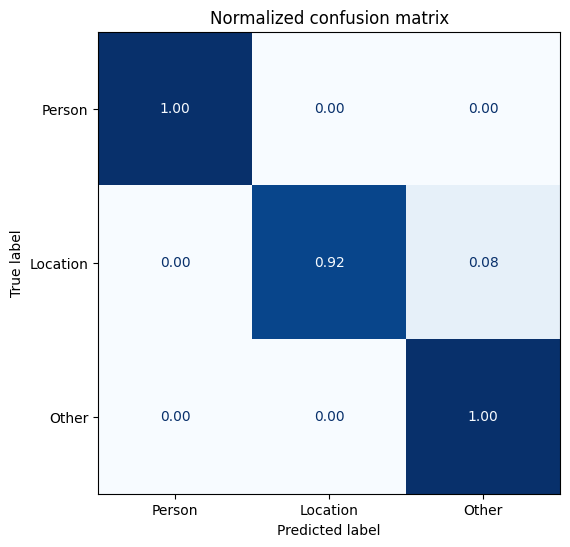

In [244]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ['Person', 'Location', 'Other']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(segments_encoded["test"]["label"])

plot_confusion_matrix(y_preds, y_valid, labels)